## Step 1: Load and Split Data

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

# Load cleaned data
df = pd.read_csv("../data/processed/cleaned_bank_churn.csv")

# Separate features and target
X = df.drop("Exited", axis=1)
y = df["Exited"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")


Train shape: (8000, 10)
Test shape: (2000, 10)


## Step 2: Train XGBoost Classifier

In [5]:
from xgboost import XGBClassifier

model = XGBClassifier(eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


### Step 3: Evaluate Model Performance

              precision    recall  f1-score   support

           0       0.87      0.94      0.91      1593
           1       0.68      0.47      0.56       407

    accuracy                           0.85      2000
   macro avg       0.78      0.71      0.73      2000
weighted avg       0.83      0.85      0.84      2000



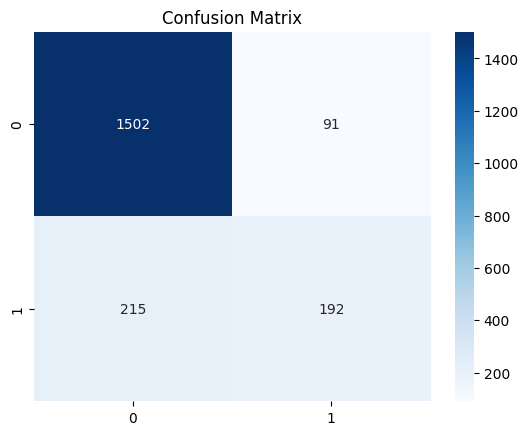

ROC AUC Score: 0.8330


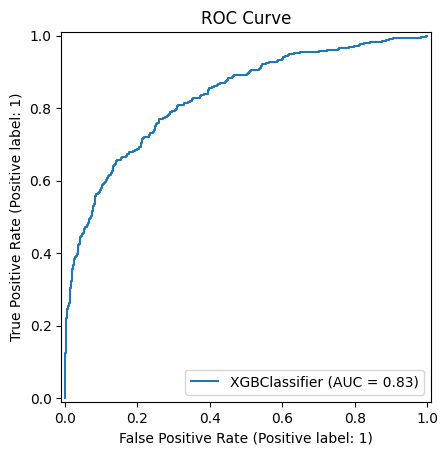

In [8]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ROC AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# ROC curve
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("ROC Curve")
plt.show()


### Step 4: Feature Importance

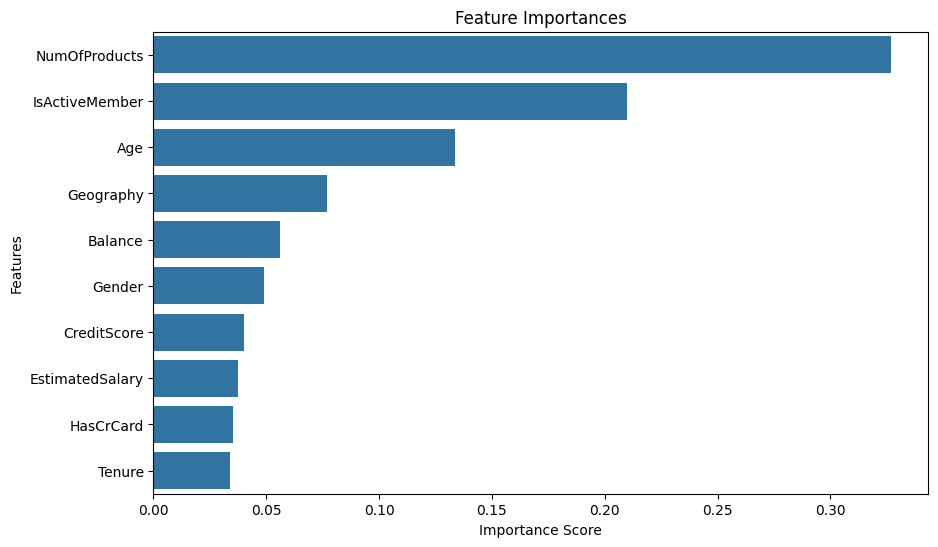

In [9]:
import numpy as np

# Plot top features
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Feature names sorted
feature_names = X.columns[indices]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=feature_names)
plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()
